# AIMNet2 tmQM-OpenFF

## Import AIMNet2 tmQM-OpenFF trainings

In [2]:
import glob
import importlib
import os
import sys
import statistics

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import wandb

import helper
from helper import extract_config, calculate_reference_energy
from modelforge.dataset.dataset import initialize_datamodule
from modelforge.dataset.utils import RandomRecordSplittingStrategy, SplittingStrategy
from modelforge.potential.potential import load_inference_model_from_checkpoint

sns.set_theme()
sns.set_context("notebook")

In [3]:
api = wandb.Api()
runs = api.runs(
    "modelforge_nnps/aimnet2_qm9",
    # filters={"group": "exp08_3"},
)
print(f"Found {len(runs)} runs")
summary_list, config_list, name_list = [], [], []

Found 320 runs


In [4]:
extract_config(runs[0].config["training_parameter"], "tags")

{'tags': ['seed=42',
  'number_of_radial_basis_functions=32',
  'number_of_vector_features=4',
  'number_of_per_atom_features=64',
  '0.1.4+300.gef9c8be.dirty',
  'QM9',
  'AimNet2',
  'loss-per_system_energy',
  'loss-per_system_dipole_moment',
  'loss-per_atom_charge']}

In [5]:
runs[0].summary["val/per_system_energy/mae"]

3.5532584190368652

In [16]:
exp_results = []

for run in runs:
    if run.state == "finished":
        record = {}
    
        record.update({"name": run.name})
        
        training_parameter = run.config["training_parameter"]
        potential_parameter = run.config['potential_parameter']
        tags = extract_config(training_parameter, "tags")["tags"]

        try:
            record.update({
                "test/per_system_energy/mae": run.summary["test/per_system_energy/mae"],
                "test/per_system_energy/rmse": run.summary["test/per_system_energy/rmse"],
                "test/per_system_dipole_moment/mae": run.summary["test/per_system_dipole_moment/mae"],
                "test/per_atom_charge/mae": run.summary["test/per_atom_charge/mae"],
                "test/per_atom_charge/rmse": run.summary["test/per_atom_charge/rmse"],

            })
        except KeyError:
            record.update({
                "test/per_system_energy/mae": pd.NA,
                "test/per_system_energy/rmse": pd.NA,
                "test/per_system_dipole_moment/mae": pd.NA,
                "test/per_atom_charge/mae": pd.NA,
            })
        record.update({
                "val/per_system_energy/mae": run.summary["val/per_system_energy/mae"],
                "val/per_system_energy/rmse": run.summary["val/per_system_energy/rmse"],
                "val/per_system_dipole_moment/mae": run.summary["val/per_system_dipole_moment/mae"],
                "val/per_atom_charge/mae": run.summary["val/per_atom_charge/mae"],
            })
        
        record.update(extract_config(potential_parameter, "number_of_radial_basis_functions"))
        record.update(extract_config(potential_parameter, "number_of_vector_features"))
        record.update(extract_config(potential_parameter, "number_of_per_atom_features"))

        loss_weights = extract_config(training_parameter, "weight")
        record.update(loss_weights["weight"])

        if "spin_multiplicity_embedding" in tags:
            record["spin_embedding"] = True
        else:
            record["spin_embedding"] = False

        record["group"] = run.group
        record.update(
            extract_config(training_parameter, "seed")
        )
        exp_results.append(record)

exp_results_df = pd.DataFrame(exp_results)

In [17]:
exp_results_df.sort_values(by="test/per_system_energy/mae").head(20)

,name,test/per_system_energy/mae,test/per_system_energy/rmse,test/per_system_dipole_moment/mae,test/per_atom_charge/mae,test/per_atom_charge/rmse,val/per_system_energy/mae,val/per_system_energy/rmse,val/per_system_dipole_moment/mae,val/per_atom_charge/mae,number_of_radial_basis_functions,number_of_vector_features,number_of_per_atom_features,per_system_energy,per_system_dipole_moment,per_atom_charge,spin_embedding,group,seed
210,09_64_8_512_(45),1.898730,3.807882,0.033123,0.297903,0.330126,1.900885,3.846545,0.033180,0.297929,64,8,512,1.0,0.0,0.0,False,exp09,45
219,09_128_4_512_(45),1.900356,3.769271,0.022755,0.177162,0.249038,1.914378,4.326655,0.022508,0.176317,128,4,512,1.0,0.0,0.0,False,exp09,45
86,09_64_8_512_(43),1.941148,3.641942,0.031870,0.175382,0.246817,1.923685,3.607409,0.031720,0.175583,64,8,512,1.0,0.0,0.0,False,exp09,43
214,09_64_16_512_(45),1.941186,3.374906,0.027222,0.212864,0.236523,1.952773,3.594153,0.027402,0.212729,64,16,512,1.0,0.0,0.0,False,exp09,45
223,09_128_8_512_(45),2.023747,4.115062,0.039395,0.191409,0.214447,2.042593,4.474545,0.039126,0.191001,128,8,512,1.0,0.0,0.0,False,exp09,45
11,09_32_16_512_(42),2.061841,16.719595,0.030670,0.228230,0.325720,1.939666,3.305192,0.030558,0.229058,32,16,512,1.0,0.0,0.0,False,exp09,42
98,09_128_4_512_(43),2.078601,4.194417,0.039668,0.184811,0.264925,2.047577,3.915352,0.039719,0.185411,128,4,512,1.0,0.0,0.0,False,exp09,43
149,09_64_8_512_(44),2.080881,4.423143,0.023940,0.239747,0.312869,2.077810,4.005641,0.023851,0.238983,64,8,512,1.0,0.0,0.0,False,exp09,44
141,09_32_32_512_(44),2.153073,3.718449,0.034652,0.282305,0.307651,2.166554,3.640182,0.034652,0.281826,32,32,512,1.0,0.0,0.0,False,exp09,44
31,09_64_32_512_(42),2.162071,4.138996,0.047956,0.378994,0.408855,2.173573,3.863286,0.048241,0.379412,64,32,512,1.0,0.0,0.0,False,exp09,42


In [18]:
exp_results_df.sort_values(by="test/per_system_energy/mae").tail(20)

,name,test/per_system_energy/mae,test/per_system_energy/rmse,test/per_system_dipole_moment/mae,test/per_atom_charge/mae,test/per_atom_charge/rmse,val/per_system_energy/mae,val/per_system_energy/rmse,val/per_system_dipole_moment/mae,val/per_atom_charge/mae,number_of_radial_basis_functions,number_of_vector_features,number_of_per_atom_features,per_system_energy,per_system_dipole_moment,per_atom_charge,spin_embedding,group,seed
10,09_32_16_256_(42),3.618124e+02,4.158563e+04,0.031040,0.326470,0.647142,2.407815,3.792691,0.031300,0.325719,32,16,256,1.0,0.0,0.0,False,exp09,42
159,09_128_4_128_(44),3.802675e+02,4.364961e+04,0.030414,0.254396,0.592053,3.088180,5.136732,0.030304,0.252562,128,4,128,1.0,0.0,0.0,False,exp09,44
49,09_256_4_128_(42),6.094866e+02,7.012682e+04,0.035407,0.247362,0.745905,3.469022,8.675256,0.035479,0.246217,256,4,128,1.0,0.0,0.0,False,exp09,42
153,09_64_16_512_(44),2.776576e+03,3.210306e+05,0.029814,0.267678,1.444795,2.105600,3.555338,0.029867,0.262356,64,16,512,1.0,0.0,0.0,False,exp09,44
145,09_64_4_512_(44),2.949719e+03,3.410463e+05,0.027707,0.268631,1.487091,2.194936,3.762741,0.027636,0.263552,64,4,512,1.0,0.0,0.0,False,exp09,44
23,09_64_8_512_(42),6.754849e+03,7.813179e+05,0.026542,0.202189,2.222211,2.317175,4.507416,0.026387,0.194759,64,8,512,1.0,0.0,0.0,False,exp09,42
16,09_64_4_256_(42),1.235612e+05,1.429655e+07,0.057029,0.386174,9.439237,2.589765,4.781177,0.057165,0.351852,64,4,256,1.0,0.0,0.0,False,exp09,42
161,09_128_4_512_(44),7.390683e+05,8.551492e+07,0.041635,0.308544,23.095903,2.281838,3.868031,0.041574,0.224429,128,4,512,1.0,0.0,0.0,False,exp09,44
53,09_256_8_128_(42),8.291527e+05,9.593815e+07,0.035419,0.321549,24.436304,3.566510,6.965249,0.035244,0.233763,256,8,128,1.0,0.0,0.0,False,exp09,42
39,09_128_8_512_(42),1.450478e+06,1.678296e+08,0.024397,0.336829,32.318489,2.359905,5.068905,0.024286,0.218984,128,8,512,1.0,0.0,0.0,False,exp09,42


## Plotting training results

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_context("notebook")

### Dataset splitting consistency

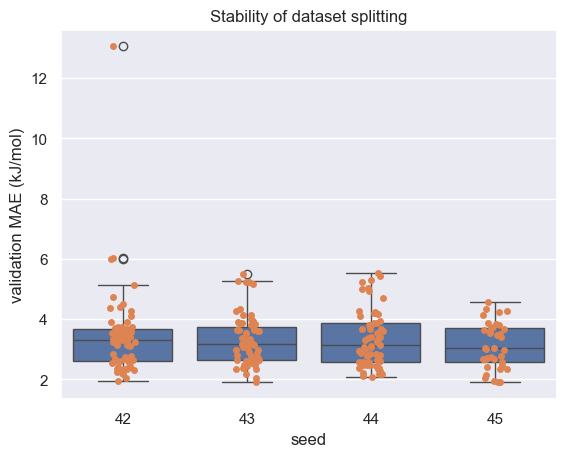

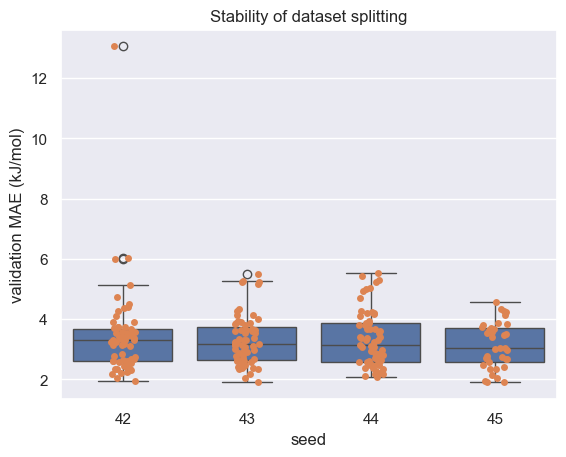

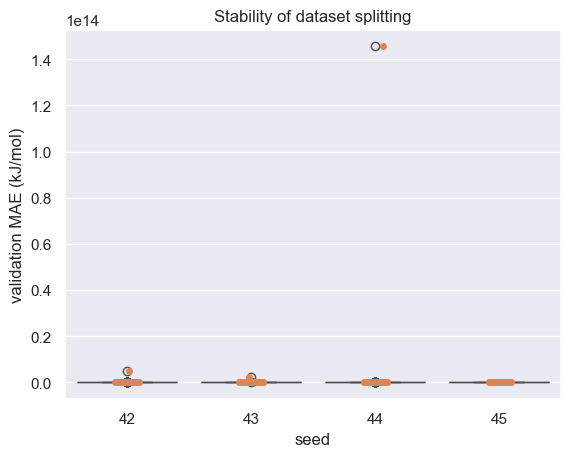

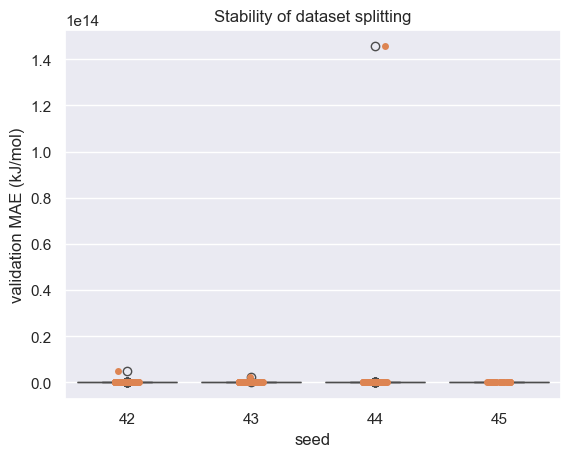

In [9]:
ax = sns.boxplot(
    data=exp_results_df,
    x="seed",
    y="val/per_system_energy/mae",
)
sns.stripplot(
    data=exp_results_df, 
    x="seed", 
    y="val/per_system_energy/mae", 
    legend=False,
)
ax.set_ylabel("validation MAE (kJ/mol)")
ax.set_title("Stability of dataset splitting")
# ax.set_ylim(45, 90)
plt.show()

ax = sns.boxplot(
    data=exp_results_df,
    x="seed",
    y="val/per_system_energy/mae",
)
sns.stripplot(
    data=exp_results_df, 
    x="seed", 
    y="val/per_system_energy/mae", 
    legend=False,
)
ax.set_ylabel("validation MAE (kJ/mol)")
ax.set_title("Stability of dataset splitting")
# ax.set_ylim(40, 350)
plt.show()

ax = sns.boxplot(
    data=exp_results_df,
    x="seed",
    y="test/per_system_energy/mae",
)
sns.stripplot(
    data=exp_results_df, 
    x="seed", 
    y="test/per_system_energy/mae", 
    legend=False,
)
ax.set_ylabel("validation MAE (kJ/mol)")
ax.set_title("Stability of dataset splitting")
# ax.set_ylim(40, 350)
plt.show()

ax = sns.boxplot(
    data=exp_results_df,
    x="seed",
    y="test/per_system_energy/mae",
)
sns.stripplot(
    data=exp_results_df, 
    x="seed", 
    y="test/per_system_energy/mae", 
    legend=False,
)
ax.set_ylabel("validation MAE (kJ/mol)")
ax.set_title("Stability of dataset splitting")
# ax.set_ylim(45, 90)
plt.show()

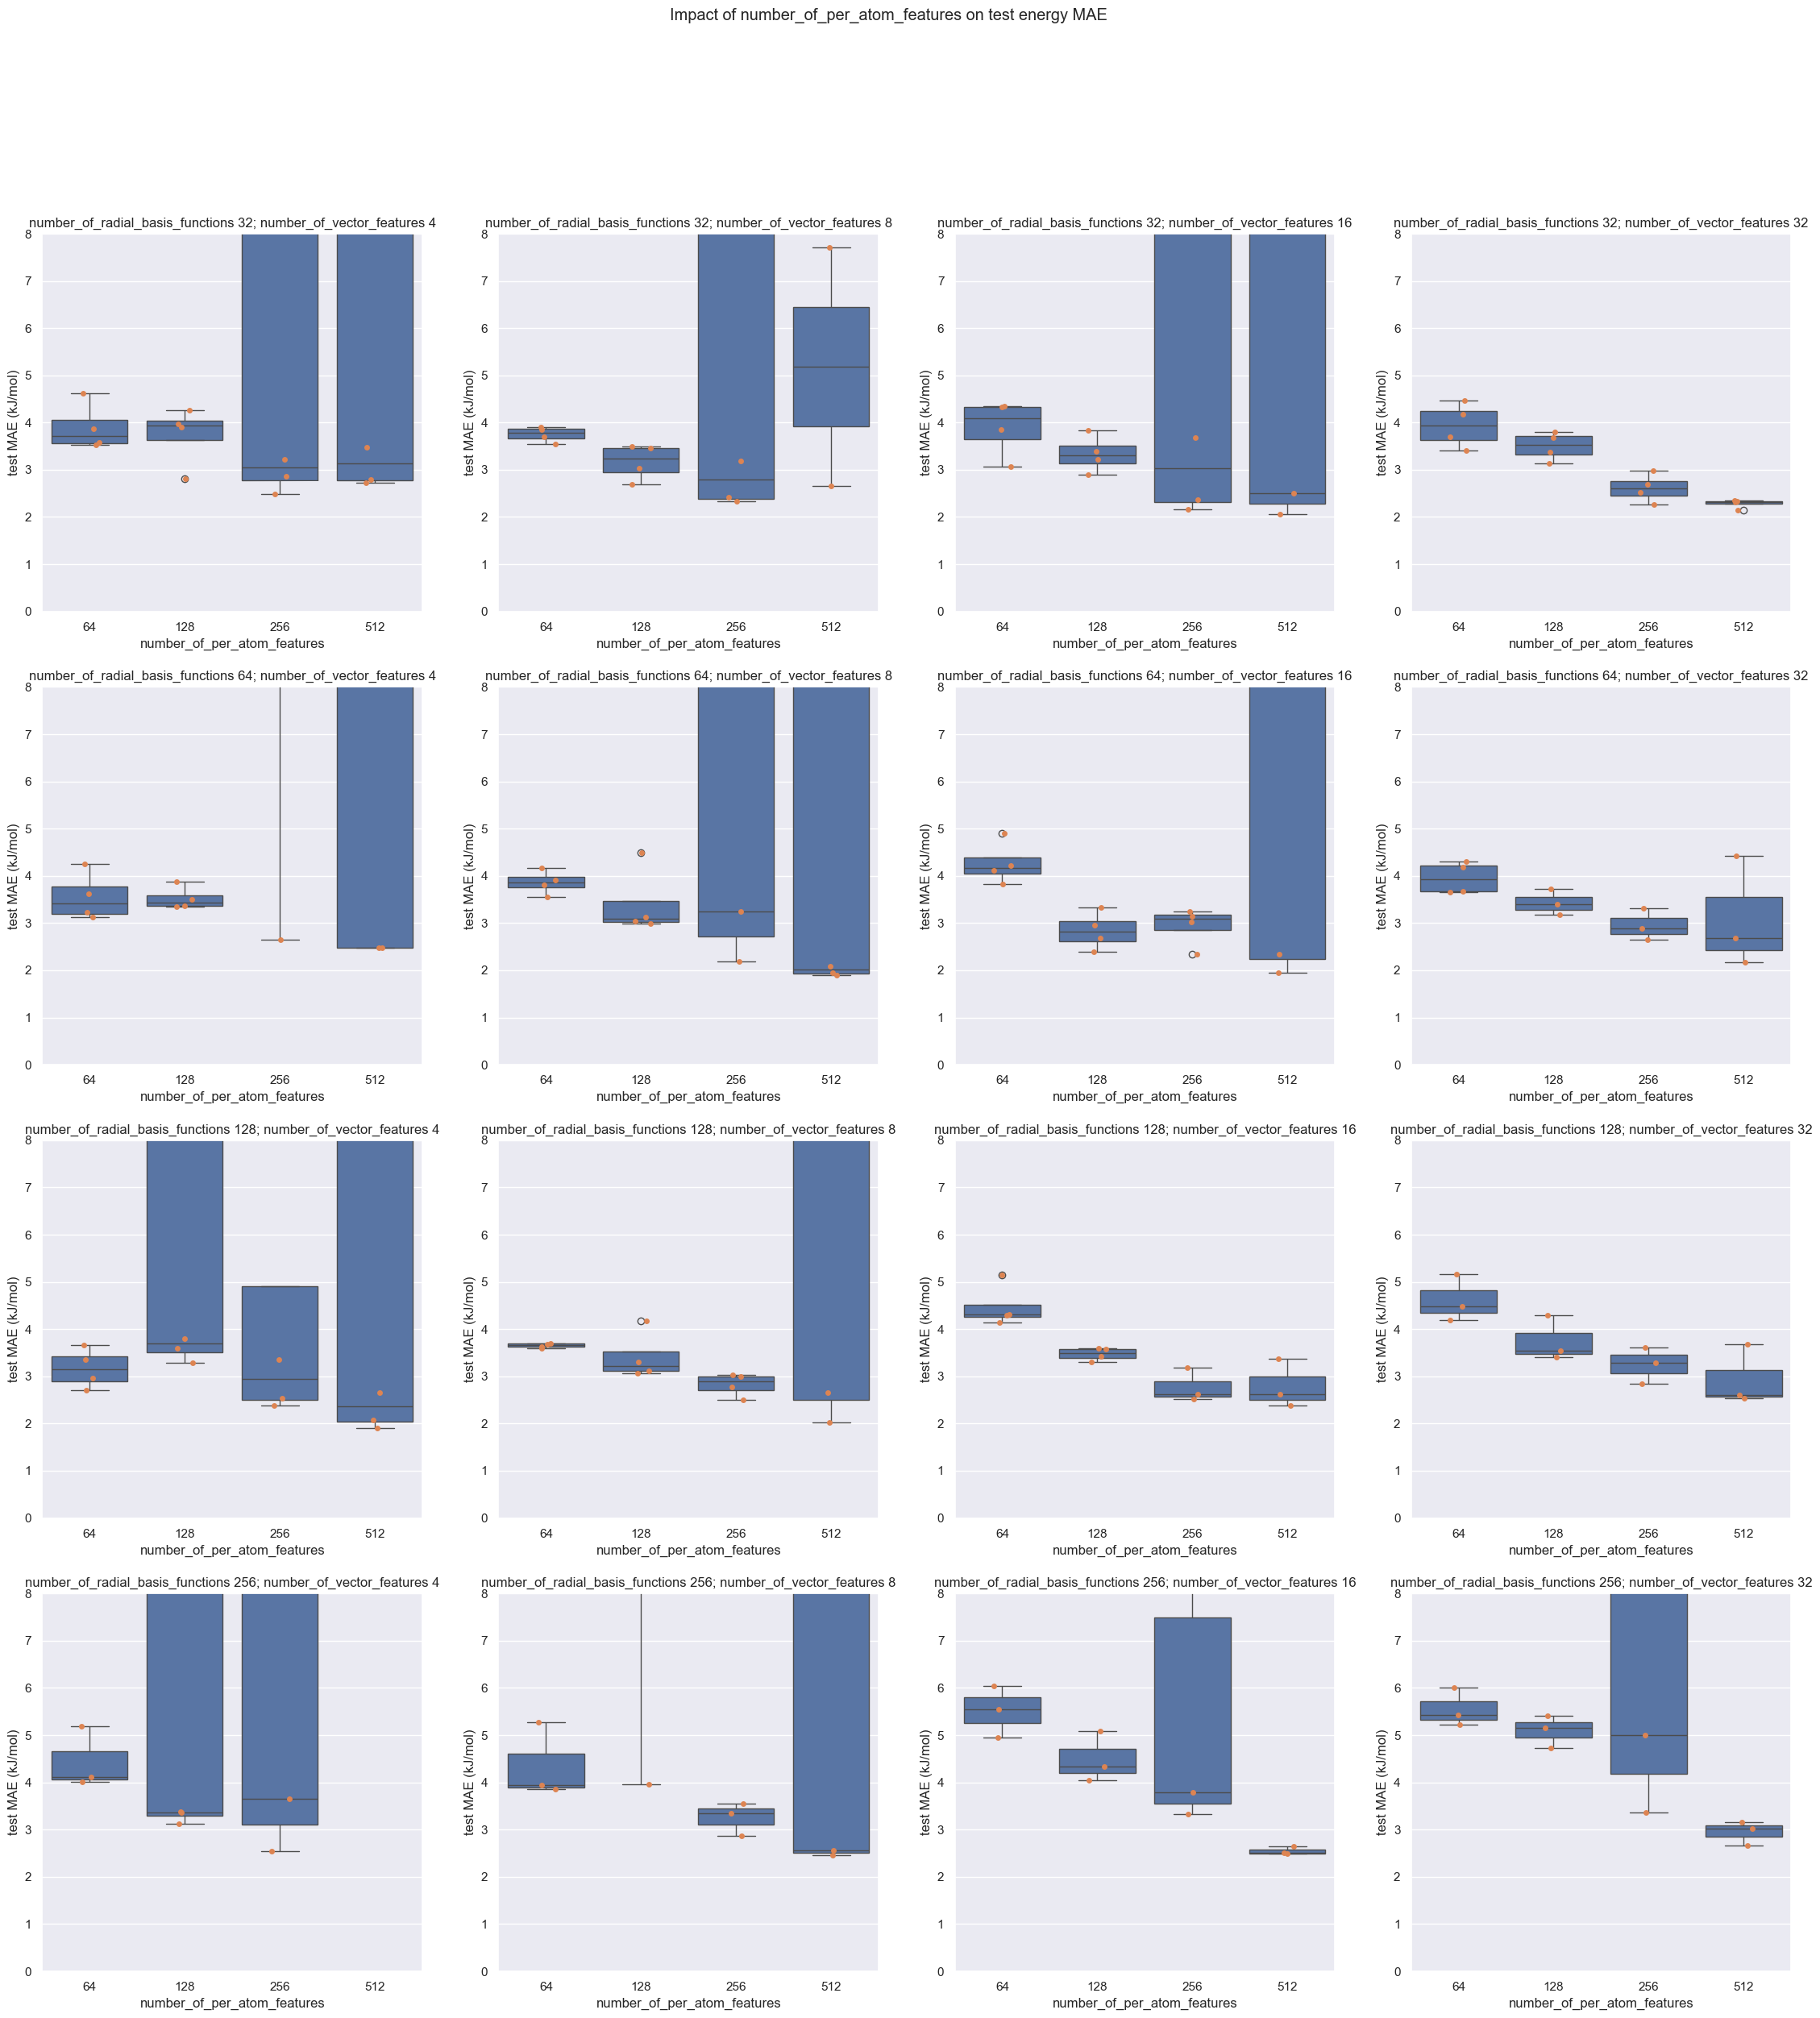

In [16]:
fig, axes = plt.subplots(4, 4, figsize=(28, 28))
fig.suptitle("Impact of number_of_per_atom_features on test energy MAE")

for i, number_of_radial_basis_functions in enumerate([32, 64, 128, 256]):
    for j, number_of_vector_features in enumerate([4, 8, 16, 32]):
        plot_results = exp_results_df[
            (exp_results_df["number_of_radial_basis_functions"] == number_of_radial_basis_functions) & \
            (exp_results_df["number_of_vector_features"] == number_of_vector_features)
        ]
        sns.boxplot(
            ax=axes[i, j],
            data=plot_results,
            x="number_of_per_atom_features",
            y="test/per_system_energy/mae",
            # hue="maximum_interaction_radius",
        )
        sns.stripplot(
            ax=axes[i, j],
            data=plot_results, 
            x="number_of_per_atom_features",
            y="test/per_system_energy/mae",
            # hue="maximum_interaction_radius",
            legend=False,
        )
        axes[i, j].set_ylim(0, 8)
        axes[i, j].set_ylabel("test MAE (kJ/mol)")
        axes[i, j].set_title(f"number_of_radial_basis_functions {number_of_radial_basis_functions}; number_of_vector_features {number_of_vector_features}")

# fig.tight_layout()